# 🧺 Filter
---

This notebook combines the disaggregated palay and corn dataset with the more general "other" crop dataset.

We then use a sequence of filtering rules (i.e., dropping uninformative time series).

**Number of Disaggregated Crops**: 325

**Number of Disaggregated Time Series**: 10949

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Disaggregated version
df1 = pd.read_csv('../data/crop-other-augmented.csv', index_col=list(range(4)))             # 343 + Coffee = 344 Crops x 83 Provinces -> 28552 time series
df2 = pd.read_csv('../data/crop-palay-corn-disagg-augmented.csv', index_col=list(range(4))) #                  4 Crops x 83 Provinces -> 332 time series
df  = pd.concat([df1, df2])                                                                 # 28552 + 332  = 28884
df

Aggregated  \
Crop        Commodity                     Province            Region                                                           
Abaca       Non-Food and Industrial Crops Abra                CORDILLERA ADMINISTRATIVE REGION (CAR)                   False   
                                          Agusan del Norte    REGION XIII (CARAGA)                                     False   
                                          Agusan del Sur      REGION XIII (CARAGA)                                     False   
                                          Aklan               REGION VI (WESTERN VISAYAS)                              False   
                                          Albay               REGION V (BICOL REGION)                                  False   
...                                                                                                                      ...   
Yellow Corn Cereal                        Tawi-tawi           BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANAO...       False   
                                          Zambales            REGION III (CENTRAL LUZON)                               False   
                                          Zamboanga Sibugay   REGION IX (ZAMBOANGA PENINSULA)                          False   
                                          Zamboanga del Norte REGION IX (ZAMBOANGA PENINSULA)                          False   
                                          Zamboanga del Sur   REGION IX (ZAMBOANGA PENINSULA)                          False   

                                                                                                                  Disaggregated  \
Crop        Commodity                     Province            Region                                                              
Abaca       Non-Food and Industrial Crops Abra                CORDILLERA ADMINISTRATIVE REGION (CAR)                      False   
                                          Agusan del Norte    REGION XIII (CARAGA)                                        False   
                                          Agusan del Sur      REGION XIII (CARAGA)                                        False   
                                          Aklan               REGION VI (WESTERN VISAYAS)                                 False   
                                          Albay               REGION V (BICOL REGION)                                     False   
...                                                                                                                         ...   
Yellow Corn Cereal                        Tawi-tawi           BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANAO...           True   
                                          Zambales            REGION III (CENTRAL LUZON)                                   True   
                                          Zamboanga Sibugay   REGION IX (ZAMBOANGA PENINSULA)                              True   
                                          Zamboanga del Norte REGION IX (ZAMBOANGA PENINSULA)                              True   
                                          Zamboanga del Sur   REGION IX (ZAMBOANGA PENINSULA)                              True   

                                                                                                                   2010Q1  \
Crop        Commodity                     Province            Region                                                        
Abaca       Non-Food and Industrial Crops Abra                CORDILLERA ADMINISTRATIVE REGION (CAR)                 0.00   
                                          Agusan del Norte    REGION XIII (CARAGA)                                 110.41   
                                          Agusan del Sur      REGION XIII (CARAGA)                                 289.58   
                                          Aklan               REGION VI (WESTERN VISAYAS)                          225.9

In [18]:
# Select disaggregated crops (325 + 4 = 329 crops x 83 provinces = 27307 time series)
df_dis = df.drop(index=df[df['Aggregated'] == True].index).drop(['Aggregated', 'Disaggregated'], axis=1).T
df_dis.index = pd.PeriodIndex(df_dis.index, freq='Q')

# Drop time series of all 0s (27307 -> 11830)
df_dis = df_dis.drop(df_dis.columns[df_dis.max() == 0], axis=1)

# Drop time series if 2021 or 2022 is all 0 (11830 -> 10949)
df_dis = df_dis.drop(df_dis.columns[(df_dis.loc['2021'].max() == 0) | (df_dis.loc['2022'].max() == 0)], axis=1)
df_dis.shape

(52, 10949)

In [17]:
# Crops that were removed (these are the crops that are 'aggregated')
set(df.reset_index()['Crop'].unique()) - set(df_dis.T.reset_index()['Crop'].unique())

{'Banana',
 'Cassava',
 'Coconut',
 'Coffee',
 'Coffee - Dried Berries',
 'Coffee - Dried Berries - Others',
 'Coffee - Green Beans',
 'Coffee - Green Beans - Others',
 'Cowpea',
 'Grapes',
 'Guava',
 'Kidney Beans',
 'Loquat (Louguat)',
 'Mango',
 'Melon',
 'Onion - Mature Bulb',
 'Orchids',
 'Papaya',
 'Pechay',
 'Pepper',
 'Ramie',
 'Sugarcane',
 'Tobacco'}

## Average Quarterly Intermittence
---

To further "enrich" the dataset, we calculate an "average quarterly intermittence" statistics.

In other words, how many quarters in a year is the time series observed to be 0, on average.

- compute quarterly intermittence.
- compute average quarterly intermittence (median) then floor or ceiling.
- bin into 0, 1, 2, 3, 4.
- train global model per bin, or use simple method for higher bins.

In [21]:
# only calculate QI from first non-zero obs to final non-zero obs.
df_dis_nan = df_dis.copy()
for col in df_dis:
    non_zero_index = df_dis[col].ne(0).idxmax()
    if str(non_zero_index) != '2010Q1':
        df_dis_nan.loc[:non_zero_index-1, col] = np.nan
        
    non_zero_index = df_dis[col].ne(0)[::-1].idxmax()
    if str(non_zero_index) != '2021Q4':
        df_dis_nan.loc[non_zero_index+1:, col] = np.nan

  0%|          | 0/52 [00:00<?, ?it/s]

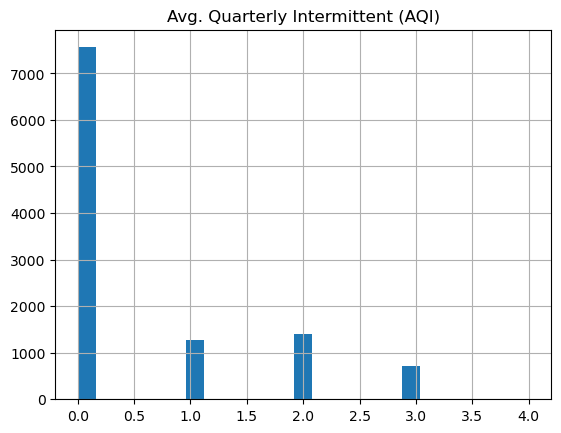

AQI
0.0    7560
1.0    1265
2.0    1398
3.0     714
4.0      12
dtype: int64

In [22]:
aqi = []
for col in tqdm(df_dis_nan):
    df_col = df_dis_nan[col]
    aqi.append(df_col[df_col.notna()].eq(0).resample('A').sum().median())
    
df_aqi = np.ceil(pd.DataFrame(data=aqi, index=df_dis.T.index, columns=['AQI']))
df_aqi.hist(bins=25)
plt.title('Avg. Quarterly Intermittent (AQI)')
plt.show()
df_aqi.value_counts().sort_index()

In [23]:
df_aqi

AQI
Crop        Commodity                     Province            Region                              
Abaca       Non-Food and Industrial Crops Agusan del Norte    REGION XIII (CARAGA)             0.0
                                          Agusan del Sur      REGION XIII (CARAGA)             0.0
                                          Aklan               REGION VI (WESTERN VISAYAS)      0.0
                                          Albay               REGION V (BICOL REGION)          0.0
                                          Antique             REGION VI (WESTERN VISAYAS)      0.0
...                                                                                            ...
Yellow Corn Cereal                        Tarlac              REGION III (CENTRAL LUZON)       0.0
                                          Zambales            REGION III (CENTRAL LUZON)       1.0
                                          Zamboanga Sibugay   REGION IX (ZAMBOANGA PENINSULA)  0.0
                                          Zamboanga del Norte REGION IX (ZAMBOANGA PENINSULA)  0.0
                                          Zamboanga del Sur   REGION IX (ZAMBOANGA PENINSULA)  0.0

[10949 rows x 1 columns]

In [24]:
df_dis_aqi = df_dis.T.copy()
df_dis_aqi.insert(loc=0, column='AQI', value=df_aqi.astype(int))
df_dis_aqi = df_dis_aqi.reset_index()
df_dis_aqi.index.name = 'id'
df_dis_aqi

,Crop,Commodity,Province,Region,AQI,2010Q1,2010Q2,2010Q3,2010Q4,2011Q1,...,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4
id,,,,,,,,,,,,,,,,,,,,,
0,Abaca,Non-Food and Industrial Crops,Agusan del Norte,REGION XIII (CARAGA),0,110.41,135.16,163.90,138.61,80.10,...,390.00,390.00,210.10,224.00,398.00,387.35,172.49,170.00,360.00,390.83
1,Abaca,Non-Food and Industrial Crops,Agusan del Sur,REGION XIII (CARAGA),0,289.58,431.05,426.83,245.40,272.76,...,954.27,520.73,509.73,1027.96,881.93,566.49,568.08,988.32,879.00,554.67
2,Abaca,Non-Food and Industrial Crops,Aklan,REGION VI (WESTERN VISAYAS),0,225.90,247.25,390.00,226.00,219.30,...,649.18,677.37,530.46,834.02,1138.30,631.14,682.47,712.91,1088.71,704.96
3,Abaca,Non-Food and Industrial Crops,Albay,REGION V (BICOL REGION),0,453.00,446.44,355.95,217.67,443.94,...,138.84,103.63,346.96,449.31,124.19,111.62,401.38,554.95,141.26,119.35
4,Abaca,Non-Food and Industrial Crops,Antique,REGION VI (WESTERN VISAYAS),0,12.75,18.00,16.81,12.33,12.24,...,14.15,17.91,15.03,17.67,14.45,18.43,15.65,17.88,14.86,14.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10944,Yellow Corn,Cereal,Tarlac,REGION III (CENTRAL LUZON),0,48700.00,50098.00,3150.00,0.00,34998.00,...,3001.00,0.00,69230.00,64519.00,3550.00,190.00,68845.00,65525.00,3120.00,419.00
10945,Yellow Corn,Cereal,Zambales,REGION III (CENTRAL LUZON),1,205.00,36.00,0.00,0.00,150.00,...,96.60,0.00,300.60,459.00,980.00,50.00,350.00,1121.00,15.50,52.84
10946,Yellow Corn,Cereal,Zamboanga Sibugay,REGION IX (ZAMBOANGA PENINSULA),0,412.00,31.00,691.00,218.00,100.00,...,2183.25,1575.00,577.76,330.00,2164.71,642.60,689.51,312.35,2327.00,330.00


In [26]:
# Out to file
df_dis_aqi.to_csv('../data/crop-v3.csv')